In [1]:
import pandas as pd
import numpy as np
df = pd.read_csv('data/jena_climate_2009_2016.csv')
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [2]:
df.shape

(420551, 15)

In [3]:
df = df.iloc[:,1:].values

array([[ 9.9652e+02, -8.0200e+00,  2.6540e+02, ...,  1.0300e+00,
         1.7500e+00,  1.5230e+02],
       [ 9.9657e+02, -8.4100e+00,  2.6501e+02, ...,  7.2000e-01,
         1.5000e+00,  1.3610e+02],
       [ 9.9653e+02, -8.5100e+00,  2.6491e+02, ...,  1.9000e-01,
         6.3000e-01,  1.7160e+02],
       ...,
       [ 9.9982e+02, -3.1600e+00,  2.7001e+02, ...,  1.0800e+00,
         2.0000e+00,  2.1520e+02],
       [ 9.9981e+02, -4.2300e+00,  2.6894e+02, ...,  1.4900e+00,
         2.1600e+00,  2.2580e+02],
       [ 9.9982e+02, -4.8200e+00,  2.6836e+02, ...,  1.2300e+00,
         1.9600e+00,  1.8490e+02]])

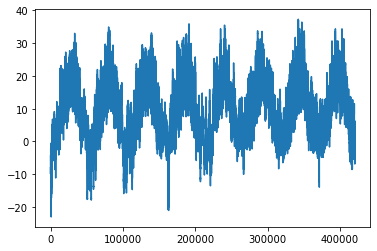

In [4]:
import matplotlib.pyplot as plt
temp = df[:,1]
plt.plot(range(len(temp)), temp)

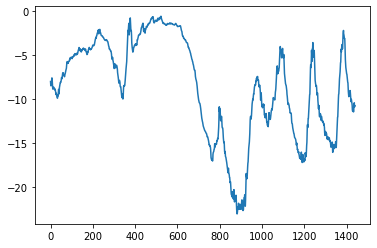

In [4]:
plt.plot(range(1440), temp[:1440]) # 10일간 (하루는 1440분 그러니 하루는 144개 데이터 이다.)

## 데이터 준비

- 정규화

In [5]:
mean = df[:200000].mean(axis=0)
df -= mean
std = df[:200000].std(axis=0)
df /= std

## 제너레이터

* `data` : 원본 데이터(배열)
* `lookback` : 입력으로 사용하기 위해 거슬러 올라갈 타임스텝
* `delay` : 타깃으로 사용할 미래의 타임스텝
* `min_index`와 `max_index` : 추출할 타임스텝의 범위를 지정하기 위한 `data` 배열의 인덱스. 검증 데이터와 테스트 데이터를 분리하는 데 사용
* `shuffle` : 샘플을 섞을지 시간 순서대로 추출할지 결정합니다.
* `batch_size` : 배치의 샘플 수
* `step` : 데이터를 샘플링할 타임스텝 간격

- step 6 = 한시간에 한번씩 데이터 추출 

In [6]:
# data = (batch_size, timestamp, features)
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1 # 전체데이터에서 delay를 빼준거 바로 전꺼까지(입력데이터 다음에 하루 target data가 있어야함)
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

In [7]:
# 1 step = 10분
my_lookback = 1440
my_step = 6
my_delay = 144
my_batch_size = 128

train_gen = generator(df,
                      lookback=my_lookback,
                      delay=my_delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=my_step, 
                      batch_size=my_batch_size)
val_gen = generator(df,
                    lookback=my_lookback,
                    delay=my_delay,
                    min_index=200001,
                    max_index=300000,
                    step=my_step,
                    batch_size=my_batch_size)
test_gen = generator(df,
                     lookback=my_lookback,
                     delay=my_delay,
                     min_index=300001,
                     max_index=None,
                     step=my_step,
                     batch_size=my_batch_size)

# 전체 검증 세트를 순회하기 위해 val_gen에서 추출할 횟수
val_steps = (300000 - 200001 - my_lookback) // my_batch_size

# 전체 테스트 세트를 순회하기 위해 test_gen에서 추출할 횟수
test_steps = (len(df) - 300001 - my_lookback) // my_batch_size

## 모델링

### 1. 24시간 뒤 온도가 동일하다면?

In [8]:
batch_maes = []
for step in range(val_steps):
    samples, targets = next(val_gen)
    preds = samples[:, -1, 1]
    mae = np.mean(np.abs(preds - targets))
    batch_maes.append(mae)
print(np.mean(batch_maes))
print(np.mean(batch_maes)*std[1])

0.28973597299054815
2.564887434980494


### 2. Dense층 사용 예제

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(Flatten(input_shape=(my_lookback // my_step, df.shape[-1])))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit(train_gen, steps_per_epoch=500, epochs=20, # sampling 한다 
                    validation_data=val_gen, validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 9s 17ms/step - loss: 1.8120 - val_loss: 0.5317
Epoch 2/20
500/500 [==============================] - 8s 16ms/step - loss: 0.4819 - val_loss: 0.3162
Epoch 3/20
500/500 [==============================] - 8s 16ms/step - loss: 0.2943 - val_loss: 0.3561
Epoch 4/20
500/500 [==============================] - 8s 16ms/step - loss: 0.2668 - val_loss: 0.3111
Epoch 5/20
500/500 [==============================] - 8s 16ms/step - loss: 0.2559 - val_loss: 0.2976
Epoch 6/20
500/500 [==============================] - 8s 17ms/step - loss: 0.2457 - val_loss: 0.3288
Epoch 7/20
500/500 [==============================] - 8s 15ms/step - loss: 0.2384 - val_loss: 0.3409
Epoch 8/20
500/500 [==============================] - 8s 16ms/step - loss: 0.2355 - val_loss: 0.3108
Epoch 9/20
500/500 [==============================] - 8s 16ms/step - loss: 0.2296 - val_loss: 0.3282
Epoch 10/20
500/500 [==============================] - 8s 16ms/step - loss: 0.2248 - val_lo

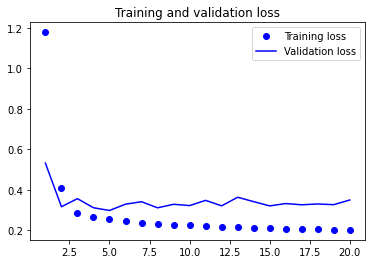

In [10]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

### 3. GRU 사용 예제

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(GRU(32, input_shape=(None, df.shape[-1])))
model.add(Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit(train_gen, steps_per_epoch=500, epochs=20,
                    validation_data=val_gen, validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 11s 19ms/step - loss: 0.3413 - val_loss: 0.2721
Epoch 2/20
500/500 [==============================] - 9s 18ms/step - loss: 0.2868 - val_loss: 0.2710
Epoch 3/20
500/500 [==============================] - 9s 18ms/step - loss: 0.2832 - val_loss: 0.2669
Epoch 4/20
500/500 [==============================] - 9s 18ms/step - loss: 0.2754 - val_loss: 0.2626
Epoch 5/20
500/500 [==============================] - 9s 19ms/step - loss: 0.2680 - val_loss: 0.2675
Epoch 6/20
500/500 [==============================] - 9s 18ms/step - loss: 0.2645 - val_loss: 0.2659
Epoch 7/20
500/500 [==============================] - 9s 18ms/step - loss: 0.2606 - val_loss: 0.2633
Epoch 8/20
500/500 [==============================] - 9s 18ms/step - loss: 0.2570 - val_loss: 0.2687
Epoch 9/20
500/500 [==============================] - 9s 18ms/step - loss: 0.2525 - val_loss: 0.2683
Epoch 10/20
500/500 [==============================] - 9s 18ms/step - loss: 0.2500 - val_l

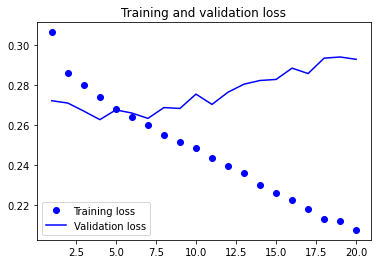

In [12]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

### 4. 순환 드롭아웃

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
#model.add(LSTM(32, dropout=0.2, recurrent_dropout=0.2, input_shape=(None, df.shape[-1])))
model.add(LSTM(32, dropout=0.2, input_shape=(None, df.shape[-1])))
model.add(Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit(train_gen, steps_per_epoch=500, epochs=20,
                    validation_data=val_gen, validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 11s 20ms/step - loss: 0.3568 - val_loss: 0.2755
Epoch 2/20
500/500 [==============================] - 9s 19ms/step - loss: 0.2925 - val_loss: 0.2748
Epoch 3/20
500/500 [==============================] - 9s 19ms/step - loss: 0.2821 - val_loss: 0.2787
Epoch 4/20
500/500 [==============================] - 9s 19ms/step - loss: 0.2740 - val_loss: 0.2771
Epoch 5/20
500/500 [==============================] - 9s 19ms/step - loss: 0.2679 - val_loss: 0.2784
Epoch 6/20
500/500 [==============================] - 9s 19ms/step - loss: 0.2620 - val_loss: 0.2803
Epoch 7/20
500/500 [==============================] - 9s 18ms/step - loss: 0.2555 - val_loss: 0.2825
Epoch 8/20
500/500 [==============================] - 9s 19ms/step - loss: 0.2521 - val_loss: 0.2851
Epoch 9/20
500/500 [==============================] - 9s 19ms/step - loss: 0.2494 - val_loss: 0.2857
Epoch 10/20
500/500 [==============================] - 9s 19ms/step - loss: 0.2428 - val_l

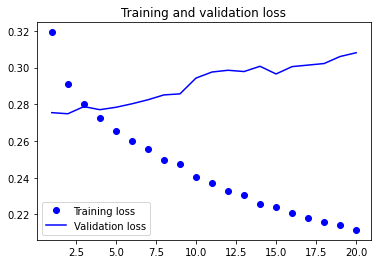

In [15]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

### 5. 스태킹 순환 층

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(GRU(32, dropout=0.1, return_sequences=True, input_shape=(None, df.shape[-1])))
model.add(GRU(64, dropout=0.1))
#model.add(GRU(64, activation='relu', dropout=0.1))
model.add(Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit(train_gen, steps_per_epoch=500, epochs=20,
                    validation_data=val_gen, validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 16s 28ms/step - loss: 0.3443 - val_loss: 0.2778
Epoch 2/20
500/500 [==============================] - 14s 27ms/step - loss: 0.2980 - val_loss: 0.2674
Epoch 3/20
500/500 [==============================] - 13s 27ms/step - loss: 0.2845 - val_loss: 0.2637
Epoch 4/20
500/500 [==============================] - 14s 27ms/step - loss: 0.2726 - val_loss: 0.2670
Epoch 5/20
500/500 [==============================] - 14s 27ms/step - loss: 0.2621 - val_loss: 0.2783
Epoch 6/20
500/500 [==============================] - 14s 27ms/step - loss: 0.2535 - val_loss: 0.2793
Epoch 7/20
500/500 [==============================] - 14s 27ms/step - loss: 0.2454 - val_loss: 0.2872
Epoch 8/20
500/500 [==============================] - 14s 27ms/step - loss: 0.2367 - val_loss: 0.2887
Epoch 9/20
500/500 [==============================] - 14s 27ms/step - loss: 0.2277 - val_loss: 0.2948
Epoch 10/20
500/500 [==============================] - 14s 27ms/step - loss: 0.218

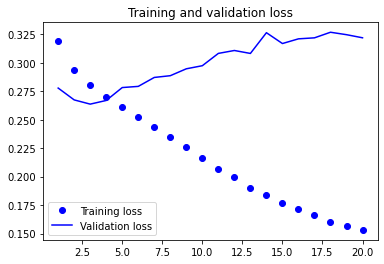

In [18]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

### 6. 역방향

In [19]:
def reverse_generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples[:, ::-1, :], targets
        
train_gen_reverse = reverse_generator(df,
                      lookback=my_lookback,
                      delay=my_delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=my_step, 
                      batch_size=my_batch_size)
val_gen_reverse = reverse_generator(df,
                    lookback=my_lookback,
                    delay=my_delay,
                    min_index=200001,
                    max_index=300000,
                    step=my_step,
                    batch_size=my_batch_size)

In [20]:
model = Sequential()
model.add(GRU(32, input_shape=(None, df.shape[-1])))
model.add(Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit(train_gen_reverse, steps_per_epoch=500, epochs=20,
                    validation_data=val_gen_reverse, validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 11s 19ms/step - loss: 0.4989 - val_loss: 0.4841
Epoch 2/20
500/500 [==============================] - 9s 19ms/step - loss: 0.4457 - val_loss: 0.4661
Epoch 3/20
500/500 [==============================] - 9s 19ms/step - loss: 0.4105 - val_loss: 0.4489
Epoch 4/20
500/500 [==============================] - 9s 19ms/step - loss: 0.3722 - val_loss: 0.4701
Epoch 5/20
500/500 [==============================] - 9s 19ms/step - loss: 0.3437 - val_loss: 0.4629
Epoch 6/20
500/500 [==============================] - 9s 19ms/step - loss: 0.3245 - val_loss: 0.4506
Epoch 7/20
500/500 [==============================] - 9s 19ms/step - loss: 0.3090 - val_loss: 0.4398
Epoch 8/20
500/500 [==============================] - 9s 19ms/step - loss: 0.2962 - val_loss: 0.4423
Epoch 9/20
500/500 [==============================] - 9s 19ms/step - loss: 0.2847 - val_loss: 0.4403
Epoch 10/20
500/500 [==============================] - 9s 19ms/step - loss: 0.2771 - val_l

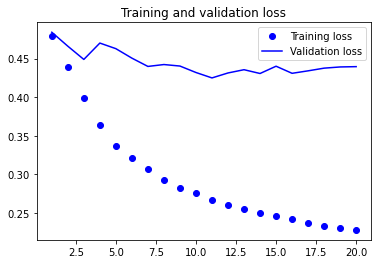

In [21]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

- 역방향을 텍스트에 적용한다면?

In [25]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.models import Sequential
max_features = 10000
maxlen = 100
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)

model = Sequential()
model.add(Embedding(max_features, 128))
model.add(LSTM(32, go_backwards=True)) # 역방향으로 LSTM 적용
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Epoch 1/10
157/157 [==============================] - 4s 18ms/step - loss: 0.5925 - acc: 0.6638 - val_loss: 0.4537 - val_acc: 0.8056
Epoch 2/10
157/157 [==============================] - 2s 15ms/step - loss: 0.3240 - acc: 0.8716 - val_loss: 0.4987 - val_acc: 0.7658
Epoch 3/10
157/157 [==============================] - 2s 15ms/step - loss: 0.2549 - acc: 0.9011 - val_loss: 0.5910 - val_acc: 0.8184
Epoch 4/10
157/157 [==============================] - 2s 15ms/step - loss: 0.2217 - acc: 0.9195 - val_loss: 0.5400 - val_acc: 0.7652
Epoch 5/10
157/157 [==============================] - 2s 15ms/step - loss: 0.1879 - acc: 0.9319 - val_loss: 0.4017 - val_acc: 0.8438
Epoch 6/10
157/157 [==============================] - 2s 15ms/step - loss: 0.1622 - acc: 0.9414 - val_loss: 0.4102 - val_acc: 0.8244
Epoch 7/10
157/157 [==============================] - 2s 16ms/step - loss: 0.1444 - acc: 0.9491 - val_loss: 0.4405 - val_acc: 0.8378
Epoch 8/10
157/157 [==============================] - 2s 15ms/step - 

### 7. 양방향

In [23]:
from tensorflow.keras import backend as K
K.clear_session()

In [26]:
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense
model = Sequential()
model.add(Embedding(max_features, 32))
model.add(Bidirectional(LSTM(32)))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(x_train, y_train, epochs=10, batch_size=128, validation_split=0.2)

Epoch 1/10
157/157 [==============================] - 5s 18ms/step - loss: 0.5975 - acc: 0.6624 - val_loss: 0.3938 - val_acc: 0.8318
Epoch 2/10
157/157 [==============================] - 2s 14ms/step - loss: 0.3394 - acc: 0.8589 - val_loss: 0.4942 - val_acc: 0.7894
Epoch 3/10
157/157 [==============================] - 2s 14ms/step - loss: 0.2750 - acc: 0.8921 - val_loss: 0.4436 - val_acc: 0.8066
Epoch 4/10
157/157 [==============================] - 2s 14ms/step - loss: 0.2165 - acc: 0.9177 - val_loss: 0.4246 - val_acc: 0.8046
Epoch 5/10
157/157 [==============================] - 2s 14ms/step - loss: 0.1970 - acc: 0.9264 - val_loss: 0.5188 - val_acc: 0.8174
Epoch 6/10
157/157 [==============================] - 2s 14ms/step - loss: 0.1809 - acc: 0.9347 - val_loss: 0.3869 - val_acc: 0.8264
Epoch 7/10
157/157 [==============================] - 2s 14ms/step - loss: 0.1586 - acc: 0.9429 - val_loss: 0.4358 - val_acc: 0.8432
Epoch 8/10
157/157 [==============================] - 2s 14ms/step - 

In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Bidirectional, Dense
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(Bidirectional(GRU(32), input_shape=(None, df.shape[-1])))
model.add(Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit(train_gen, steps_per_epoch=500, epochs=20,
                    validation_data=val_gen, validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 16s 27ms/step - loss: 0.3239 - val_loss: 0.2701
Epoch 2/20
500/500 [==============================] - 13s 27ms/step - loss: 0.2800 - val_loss: 0.2696
Epoch 3/20
500/500 [==============================] - 13s 27ms/step - loss: 0.2703 - val_loss: 0.2796
Epoch 4/20
500/500 [==============================] - 13s 27ms/step - loss: 0.2642 - val_loss: 0.2747
Epoch 5/20
500/500 [==============================] - 13s 26ms/step - loss: 0.2564 - val_loss: 0.2673
Epoch 6/20
500/500 [==============================] - 13s 26ms/step - loss: 0.2529 - val_loss: 0.2699
Epoch 7/20
500/500 [==============================] - 13s 27ms/step - loss: 0.2479 - val_loss: 0.2779
Epoch 8/20
500/500 [==============================] - 14s 27ms/step - loss: 0.2425 - val_loss: 0.2777
Epoch 9/20
500/500 [==============================] - 14s 27ms/step - loss: 0.2341 - val_loss: 0.2784
Epoch 10/20
500/500 [==============================] - 14s 27ms/step - loss: 0.228

### State관련 설정
* `return_state` : True일 경우 출력에 State를 함께 출력
* `stateful` : 각 샘플의 마지막 State를 다음 배치 때 초기 State로 설정